<a href="https://colab.research.google.com/github/theaadya/Speaker-Identification-ML-Model/blob/main/Speaker_Identification_using_Classical_ML_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imported Libraries

In [ ]:
! pip install pydub opendatasets

In [ ]:
import warnings
warnings.filterwarnings("ignore")

warnings.filterwarnings("ignore", category=DeprecationWarning)

warnings.filterwarnings("ignore", message=".*deprecated.*")

In [ ]:
import pickle
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from os.path import join
from scipy.io.wavfile import read
from scipy.io.wavfile import write
from random import randint
import joblib

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import opendatasets as od
from pydub import AudioSegment

In [ ]:
od.download('https://www.kaggle.com/datasets/kongaevans/speaker-recognition-dataset/')

In [ ]:
data_directory = "/content/drive/MyDrive/Datasets/Project_Dataset/16000_pcm_speeches"
speaker_audio = ['Benjamin_Netanyau', 'Jens_Stoltenberg','Julia_Gillard','Magaret_Tarcher','Nelson_Mandela']
noise_audio = ["_background_noise_","other"]

# EDA

##Number of audio per class

In [ ]:
def plot_classes_count(path):
  file_count = {}
  for i in path:
    p = os.listdir(data_directory + "/" + i)
    class_len = len(p)
    file_count[i] = class_len
  plt.figure(figsize=(8, 4))
  plt.bar(file_count.keys(), file_count.values(), color='black')
  plt.xlabel('Classes')
  plt.ylabel('Number of Audio')
  plt.title('Number of Audio per Classes')

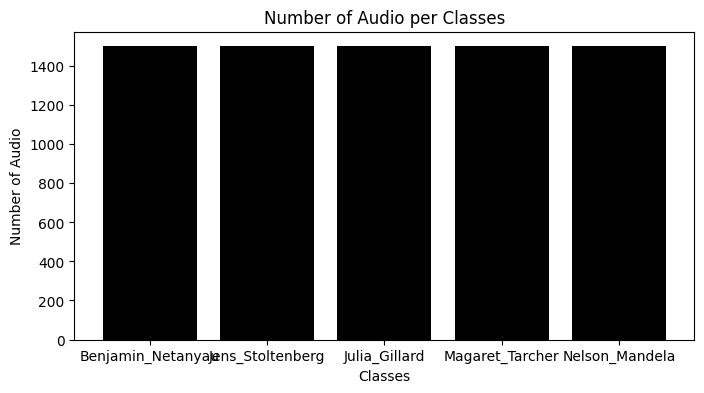

In [ ]:
plot_classes_count(speaker_audio)

* All the speaker class is well balanced.

## Number of audio in noise folder

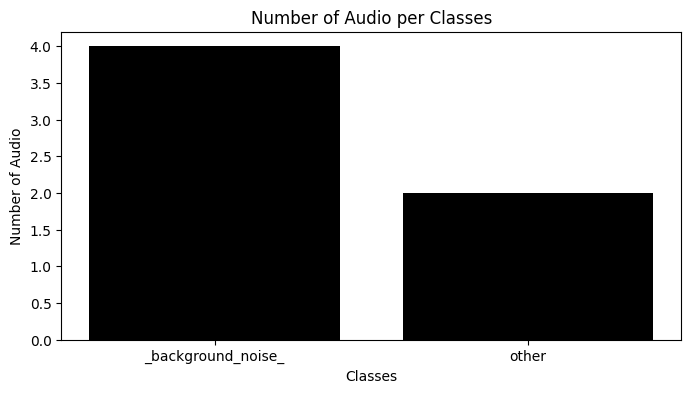

In [ ]:
plot_classes_count(noise_audio)

## Audio length of each class

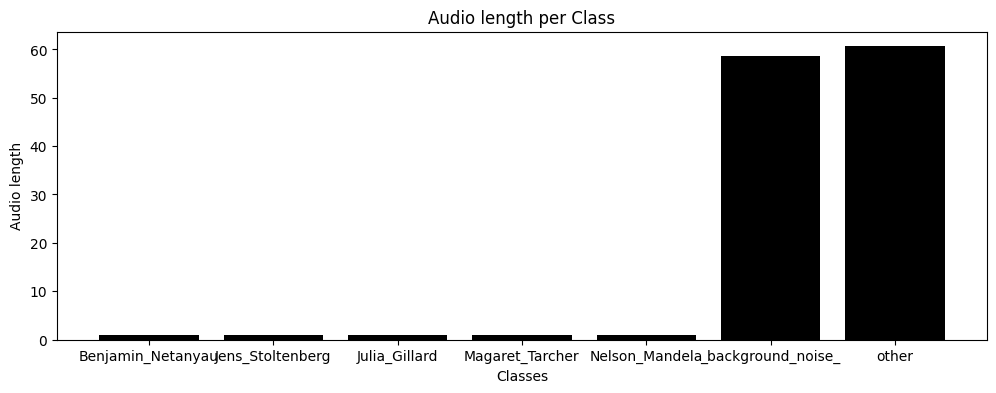

In [ ]:
class_mean_lengths = dict()
audio_classes = ['Benjamin_Netanyau', 'Jens_Stoltenberg','Julia_Gillard','Magaret_Tarcher','Nelson_Mandela',"_background_noise_","other"]

for class_name in audio_classes:
    class_folder_path = os.path.join(data_directory, class_name)
    if os.path.isdir(class_folder_path):
       class_audio_files = [os.path.join(class_folder_path, audio) for audio in os.listdir(class_folder_path) if audio.lower().endswith(('.wav'))]
       lengths = [librosa.get_duration(path=audio_file) for audio_file in class_audio_files]
       mean_length = np.mean(lengths)
       class_mean_lengths[class_name] = mean_length

plt.figure(figsize=(12, 4))
plt.bar(class_mean_lengths.keys(), class_mean_lengths.values(), color='black')
plt.xlabel('Classes')
plt.ylabel('Audio length')
plt.title('Audio length per Class')
plt.show()

* Since the noise audio is longer than the speaker's, we must chop it up into smaller pieces to blend it in with the speaker's audio.It is crucial to divide the lengthier audio clip of the noise into smaller segments that correspond to the speaker's audio duration.

In [ ]:
sample_rate = 16000

In [ ]:
def plot_waveforms_for_noise(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            y, sr = librosa.load(file_path)
            plt.figure(figsize=(10, 2))
            librosa.display.waveshow(y, sr=sr)
            plt.title(f'Waveform of {filename}')
            plt.show()

In [ ]:
def plot_waveform(audio, speaker, start_time=0, duration=15):
    print(f"Waveform of {speaker} (15 seconds):")
    start_idx = int(start_time * sample_rate)
    end_idx = int((start_time + duration) * sample_rate)
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(audio[start_idx:end_idx], sr=sample_rate)
    plt.title(f"Waveform of {speaker}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

In [ ]:
def plot_spectrograph(audio, speaker):
    print(f"\nSpectrogram of {speaker} (2 minutes):")
    D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
    plt.figure(figsize=(10, 2))
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log', cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram of {speaker}")
    plt.show()

In [ ]:
def plot_mel_spectogram(audio, speaker):
  print(f"\nMel Spectogram of {speaker}:")
  mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
  mel_db = librosa.amplitude_to_db(mel, ref=np.max)
  plt.figure(figsize = (10, 2))
  plt.title(speaker)
  librosa.display.specshow(mel_db, sr=sample_rate, x_axis = 'time',
                           y_axis = 'log', cmap = 'jet');
  plt.colorbar();
  plt.show()

In [ ]:
def plot_mfcc(audio, speaker):
    print(f"\nMFCC of {speaker}:")
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfccs, x_axis='time', cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title(speaker)
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficient')
    plt.show()

def plot_mfcc_lines(audio, speaker):
    print(f"\nMFCC of {speaker}:")
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    plt.figure(figsize=(10, 6))
    for i in range(mfccs.shape[0]):
        plt.plot(np.arange(0, mfccs.shape[1]), mfccs[i], label=f'MFCC {i + 1}')

    plt.title(speaker)
    plt.xlabel('Frame Index')
    plt.ylabel('MFCC Value')
    plt.legend()
    plt.show()

In [ ]:
def get_one_minute_audio(speaker, data_directory):
    audio_folder = os.path.join(data_directory, speaker)
    audio_data = []
    sample_rate = None

    for audio_file in os.listdir(audio_folder):
        if audio_file.endswith(".wav"):
            file_path = os.path.join(audio_folder, audio_file)
            audio, sr = librosa.load(file_path, sr=None)

            if sample_rate is None:
                sample_rate = sr

            audio_data.append(audio)

    concatenated_audio = np.concatenate(audio_data[:60])
    return concatenated_audio, sample_rate

def get_two_minute_audio(speaker, data_directory):
    audio_folder = os.path.join(data_directory, speaker)
    audio_data = []
    sample_rate = None

    for audio_file in os.listdir(audio_folder):
        if audio_file.endswith(".wav"):
            file_path = os.path.join(audio_folder, audio_file)
            audio, sr = librosa.load(file_path, sr=None)

            if sample_rate is None:
                sample_rate = sr

            audio_data.append(audio)

    concatenated_audio = np.concatenate(audio_data[:120])
    return concatenated_audio, sample_rate

## WaveForm and Spetogram of all the speakers

In [ ]:
def get_and_plot(speaker):
    audio_data, sample_rate = get_one_minute_audio(speaker, data_directory)
    audio_data_2min, sample_rate_2min = get_two_minute_audio(speaker, data_directory)

    plot_waveform(audio_data, speaker)
    plot_spectrograph(audio_data_2min, speaker)
    plot_mel_spectogram(audio_data, speaker)
    # plot_mfcc(audio_data, speaker)
    plot_mfcc_lines(audio_data, speaker)

Waveform of Benjamin_Netanyau (15 seconds):


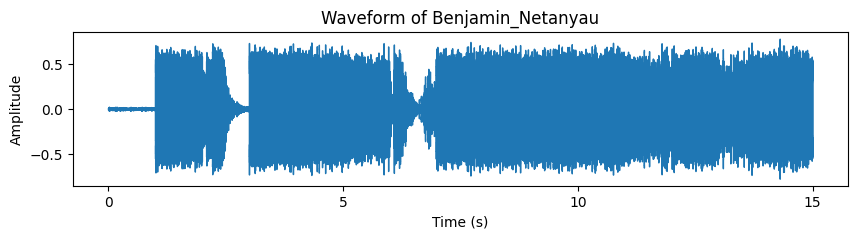


Spectrogram of Benjamin_Netanyau (2 minutes):


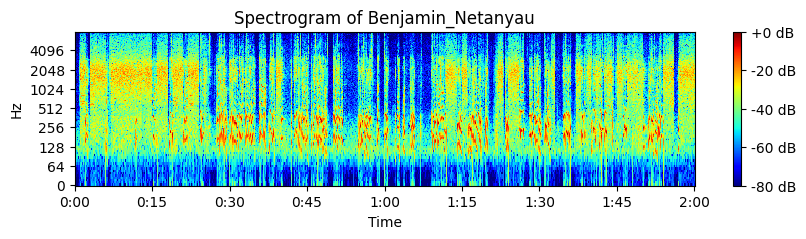


Mel Spectogram of Benjamin_Netanyau:


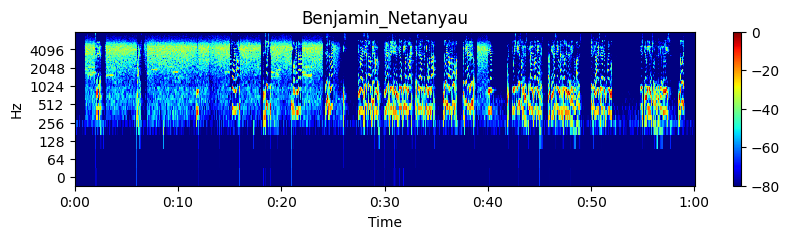


MFCC of Benjamin_Netanyau:


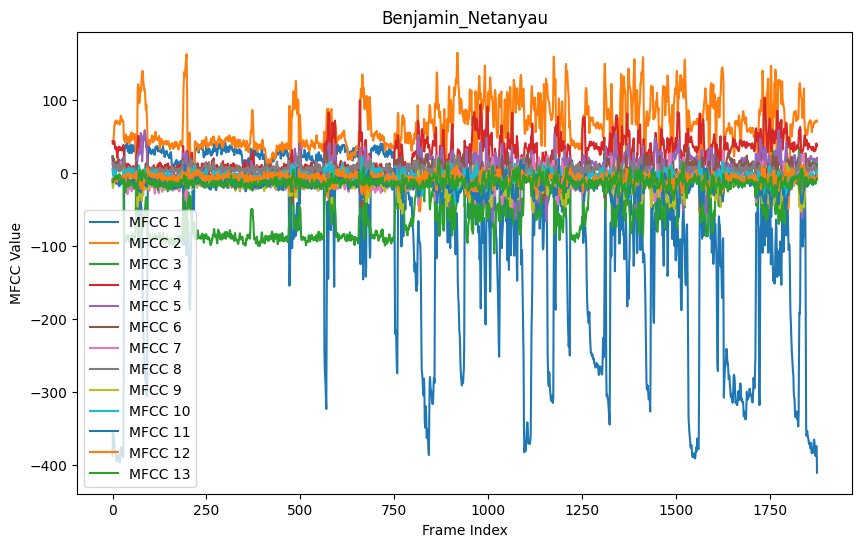

In [ ]:
get_and_plot("Benjamin_Netanyau")

Waveform of Jens_Stoltenberg (15 seconds):


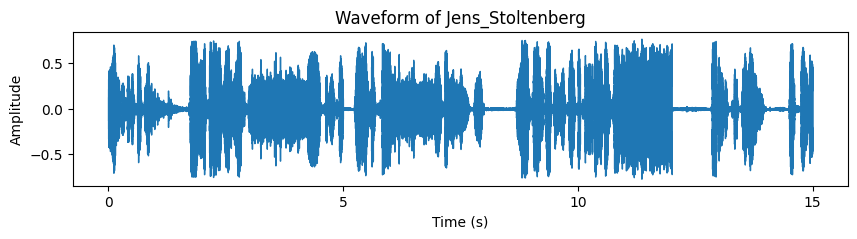


Spectrogram of Jens_Stoltenberg (2 minutes):


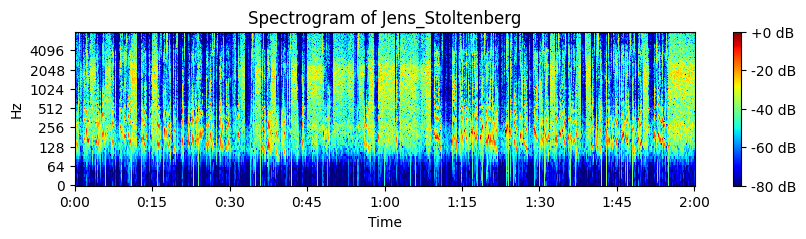


Mel Spectogram of Jens_Stoltenberg:


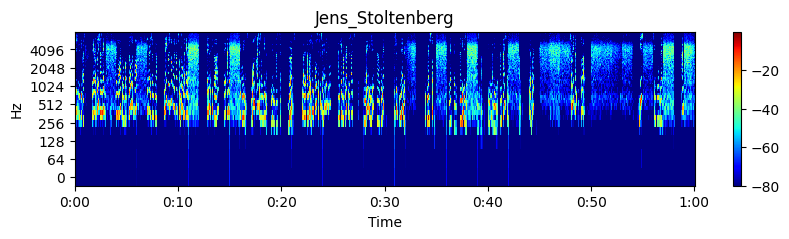


MFCC of Jens_Stoltenberg:


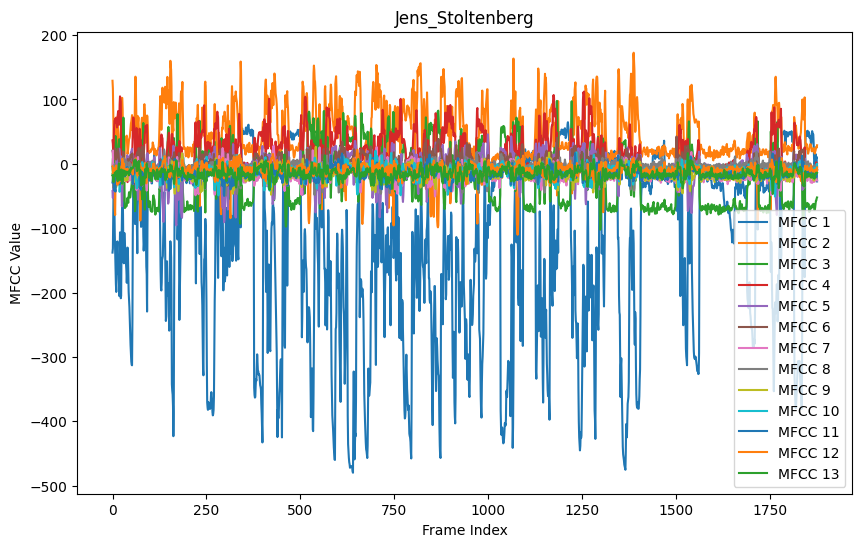

In [ ]:
get_and_plot("Jens_Stoltenberg")

Waveform of Julia_Gillard (15 seconds):


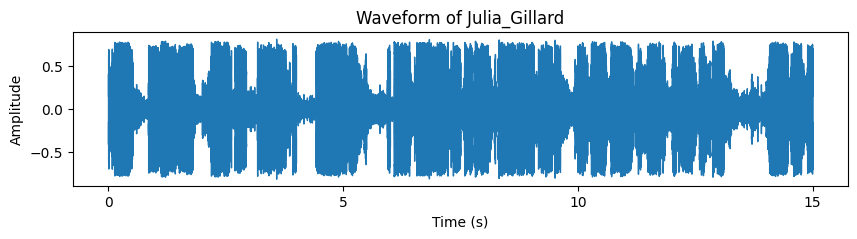


Spectrogram of Julia_Gillard (2 minutes):


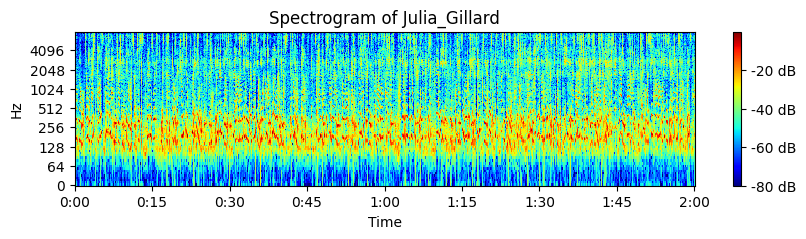


Mel Spectogram of Julia_Gillard:


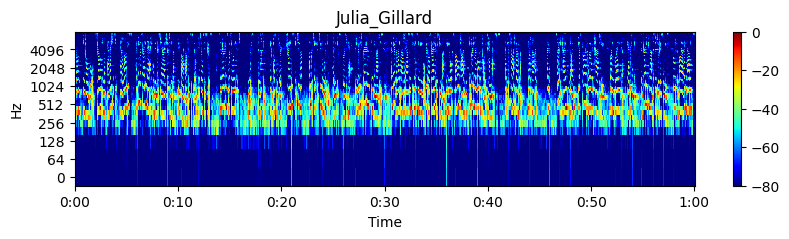


MFCC of Julia_Gillard:


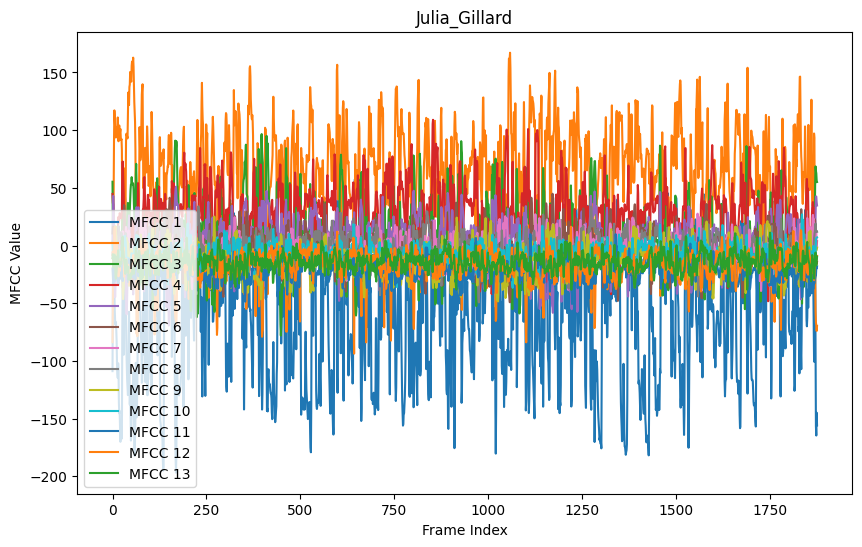

In [ ]:
get_and_plot("Julia_Gillard")

Waveform of Magaret_Tarcher (15 seconds):


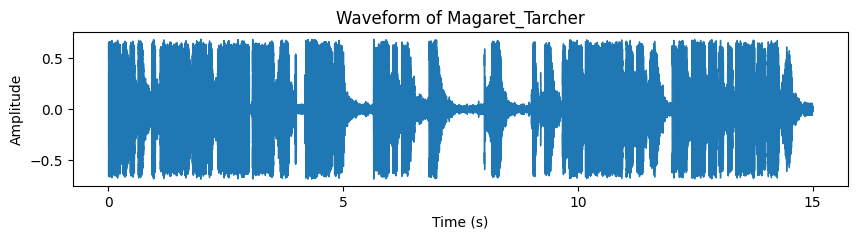


Spectrogram of Magaret_Tarcher (2 minutes):


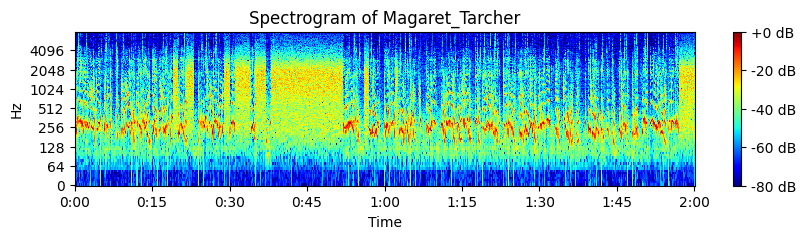


Mel Spectogram of Magaret_Tarcher:


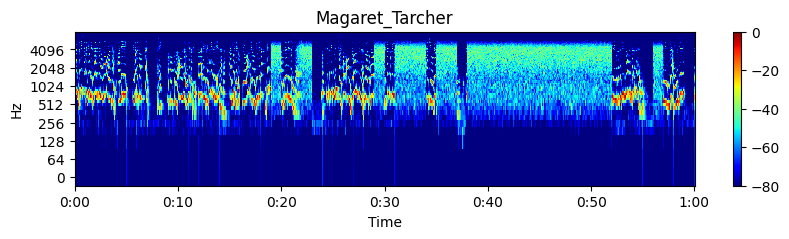


MFCC of Magaret_Tarcher:


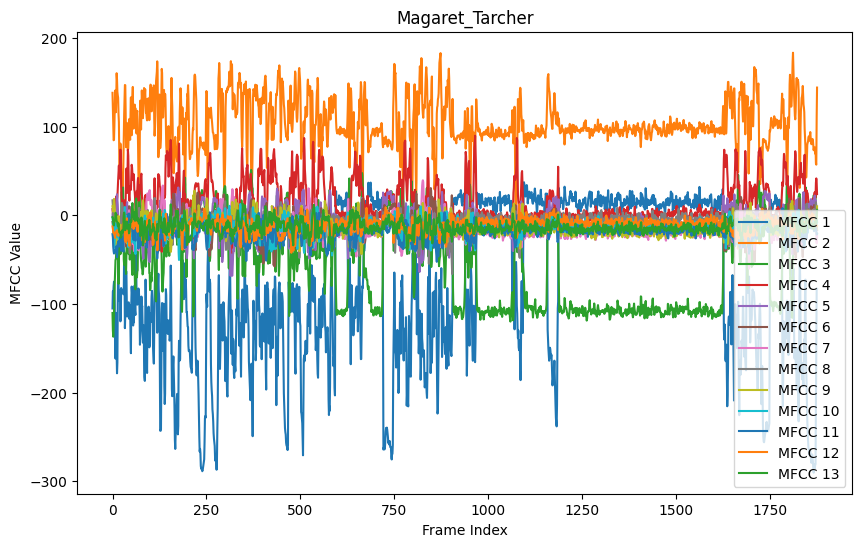

In [ ]:
get_and_plot("Magaret_Tarcher")

Waveform of Nelson_Mandela (15 seconds):


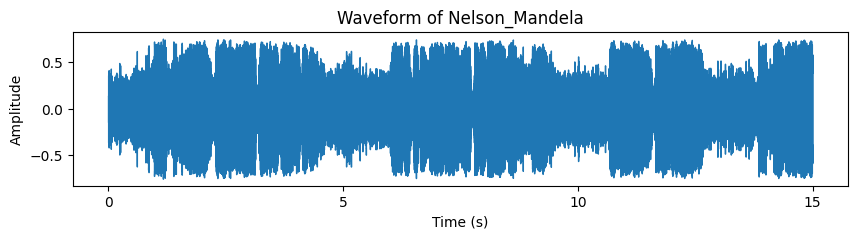


Spectrogram of Nelson_Mandela (2 minutes):


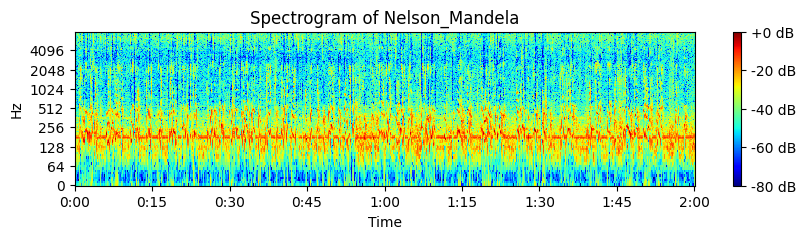


Mel Spectogram of Nelson_Mandela:


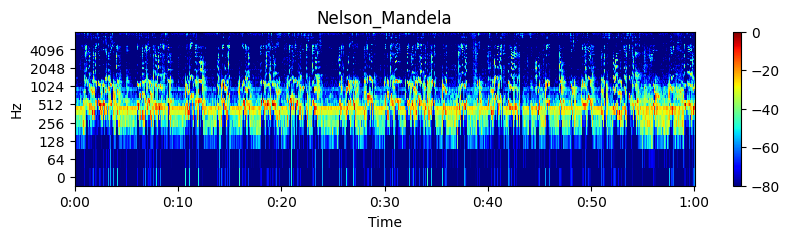


MFCC of Nelson_Mandela:


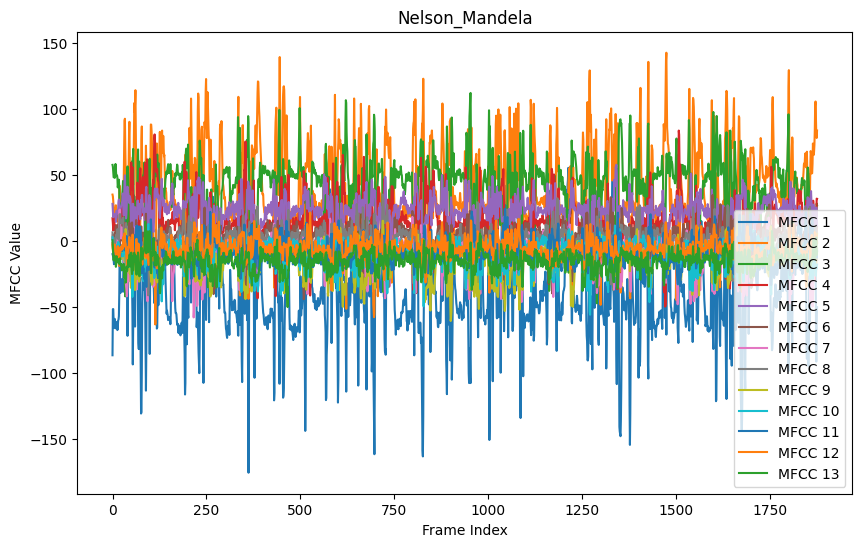

In [ ]:
get_and_plot("Nelson_Mandela")

## Waveform of different noises

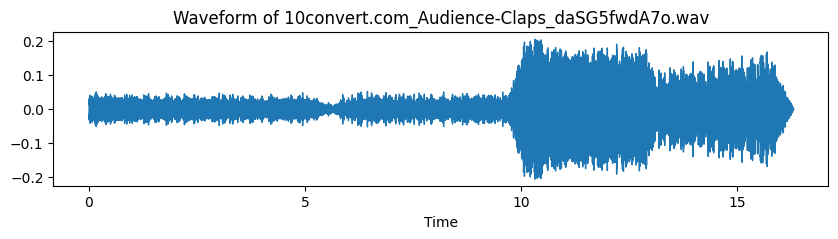

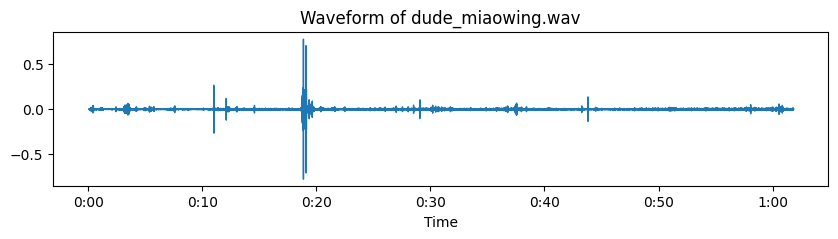

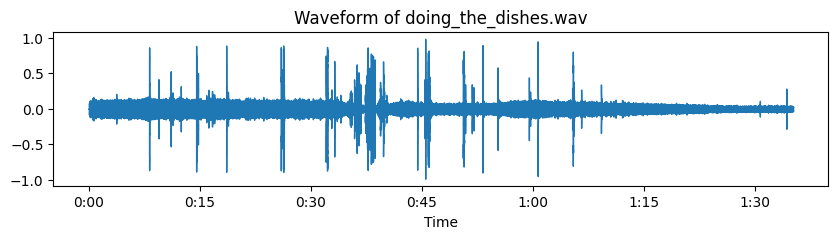

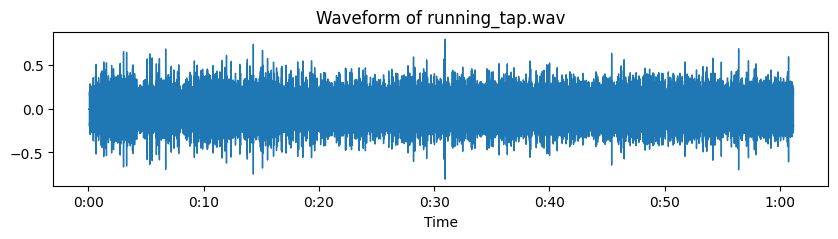

In [ ]:
audio_dir = data_directory + "/" + "_background_noise_"
plot_waveforms_for_noise(audio_dir)

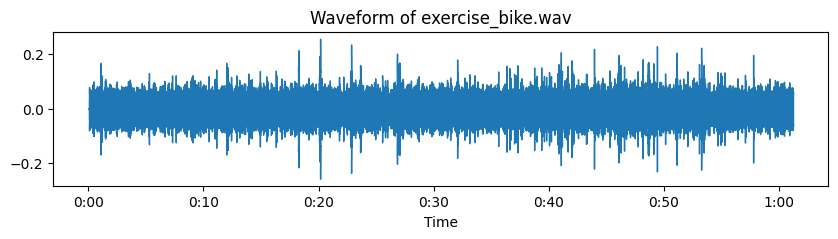

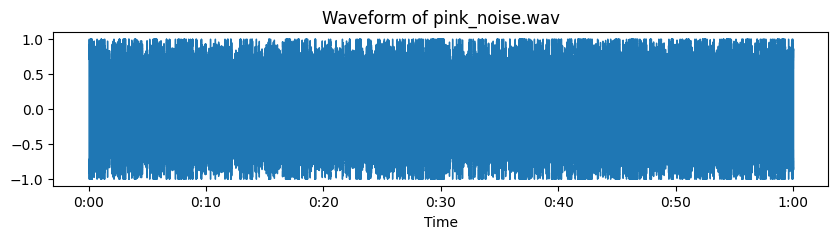

In [ ]:
audio_dir2 = data_directory + "/" + "other"
plot_waveforms_for_noise(audio_dir2)

## Statistics

In [ ]:
def calculate_audio_statistics(audio_data, sample_rate):
    pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sample_rate)
    pitch_mean = np.mean(pitches)

    rmse = librosa.feature.rms(y=audio_data)
    rmse_mean = np.mean(rmse)
    rmse_var = np.var(rmse)

    amplitude = np.abs(audio_data)
    amplitude_mean = np.mean(amplitude)
    amplitude_var = np.var(amplitude)

    return {
        "Pitch": pitch_mean,
        "RMSE": rmse_mean,
        "RMSE_Var": rmse_var,
        "Amplitude_Mean": amplitude_mean,
        "Amplitude_Var": amplitude_var,
    }

In [ ]:
for speaker in speaker_audio:
    audio_data, sample_rate = get_one_minute_audio(speaker, data_directory)
    statistics = calculate_audio_statistics(audio_data, sample_rate)

    print(f"\nStatistics for {speaker}:")
    for key, value in statistics.items():
        print(f"{key}: {value}")


Statistics for Benjamin_Netanyau:
Pitch: 94.99972534179688
RMSE: 0.15797200798988342
RMSE_Var: 0.007618904113769531
Amplitude_Mean: 0.12445974349975586
Amplitude_Var: 0.01710120588541031

Statistics for Jens_Stoltenberg:
Pitch: 102.99101257324219
RMSE: 0.1103188544511795
RMSE_Var: 0.005363829433917999
Amplitude_Mean: 0.08329593390226364
Amplitude_Var: 0.010612662881612778

Statistics for Julia_Gillard:
Pitch: 23.595867156982422
RMSE: 0.24133999645709991
RMSE_Var: 0.009716176427900791
Amplitude_Mean: 0.19138461351394653
Amplitude_Var: 0.031378284096717834

Statistics for Magaret_Tarcher:
Pitch: 65.09663391113281
RMSE: 0.23535579442977905
RMSE_Var: 0.007694399915635586
Amplitude_Mean: 0.19077610969543457
Amplitude_Var: 0.026743197813630104

Statistics for Nelson_Mandela:
Pitch: 11.292630195617676
RMSE: 0.22672124207019806
RMSE_Var: 0.0046607134863734245
Amplitude_Mean: 0.18364177644252777
Amplitude_Var: 0.022390570491552353


<!-- * Jens Stoltenberg appears to have relatively clear and consistent audio, while
Julia Gillard's audio may have distinctive spectral characteristics. Benjamin Netanyahu has the highest pitch, and Nelson Mandela has a stable audio signal with a moderate pitch. Margaret Thatcher's audio has more variation in RMSE and spectral contrast.
 -->
Benjamin Netanyau and Jens Stoltenberg tend to have higher pitch means suggesting relatively higher-pitched voices, while Julia Gillard exhibits a lower-pitched voice. The RMSE values indicate that Benjamin Netanyau and Jens Stoltenberg have more stable and consistent speech patterns, while Julia Gillard's higher RMSE suggests potential speech variations. The analysis of spectral features reveals that Jens Stoltenberg and Julia Gillard have more pronounced variations in the frequency content of their speech, while Benjamin Netanyau and Magaret Tarcher display more consistent spectral characteristics.

# PreProcessing

In [ ]:
import scipy.signal
import scipy.io.wavfile

def remove_noise(audio_data):
    hamming_window = np.hamming(len(audio_data))
    clean_audio = audio_data * hamming_window
    return clean_audio

def pre_emphasis(audio_data, alpha=0.97):
    emphasized_audio = np.append(audio_data[0], audio_data[1:] - alpha * audio_data[:-1])
    return emphasized_audio

def transform_to_frequency_domain(audio_data):
    fft_result = np.fft.fft(audio_data)
    return fft_result

## Audio Cleaning

In [ ]:
def remove_and_plot(speaker):
    audio_data_1, sample_rate = get_one_minute_audio(speaker, data_directory)
    audio_data_2, sample_rate_2 = get_two_minute_audio(speaker, data_directory)

    clean_audio_1 = remove_noise(audio_data_1)
    clean_audio_2 = remove_noise(audio_data_2)

    plot_waveform(clean_audio_1, speaker)
    plot_spectrograph(clean_audio_2, speaker)
    plot_mel_spectogram(clean_audio_1, speaker)
    plot_mfcc_lines(clean_audio_1, speaker)

Waveform of Benjamin_Netanyau (15 seconds):


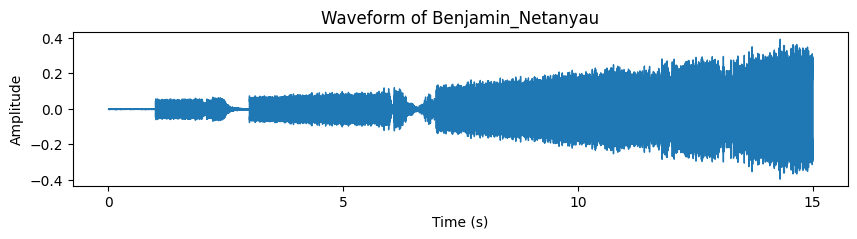


Spectrogram of Benjamin_Netanyau (2 minutes):


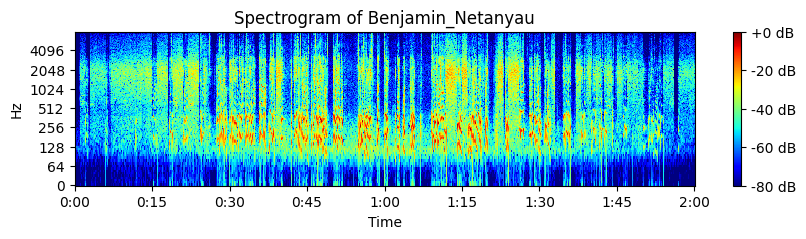


Mel Spectogram of Benjamin_Netanyau:


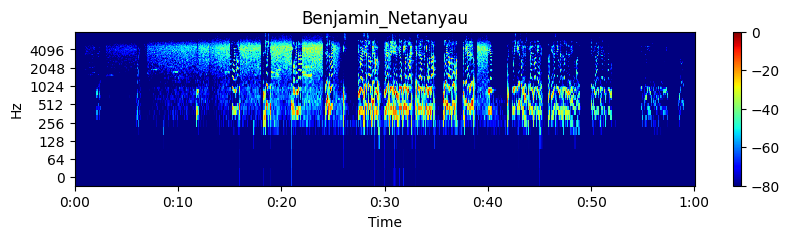


MFCC of Benjamin_Netanyau:


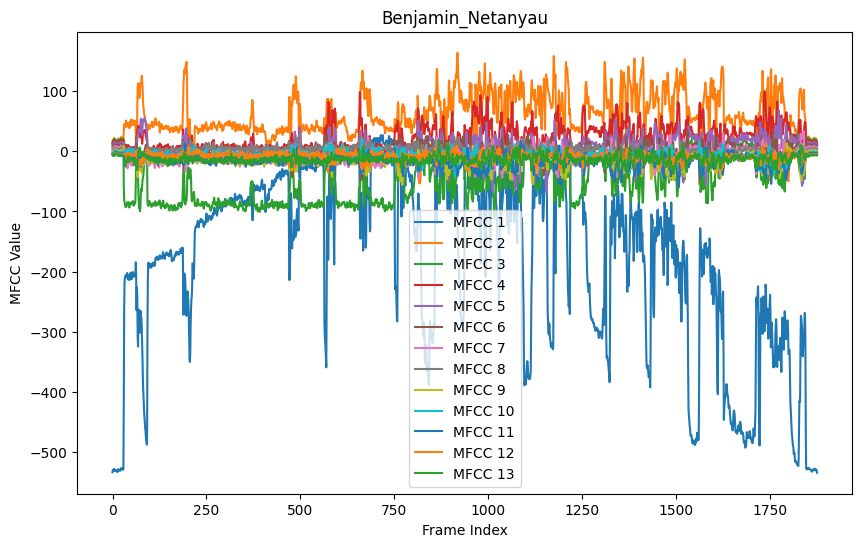

In [ ]:
remove_and_plot("Benjamin_Netanyau")

Waveform of Jens_Stoltenberg (15 seconds):


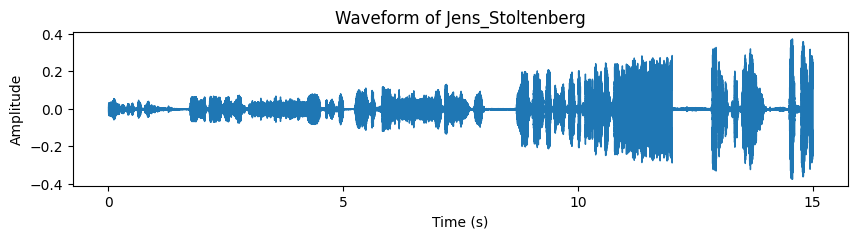


Spectrogram of Jens_Stoltenberg (2 minutes):


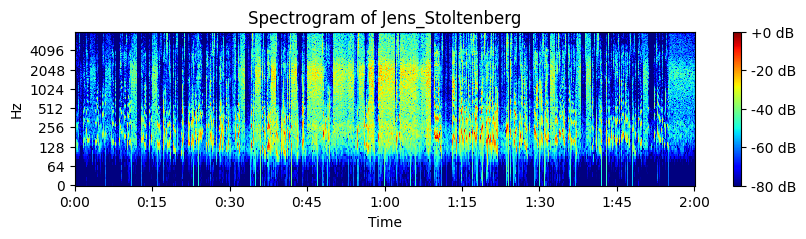


Mel Spectogram of Jens_Stoltenberg:


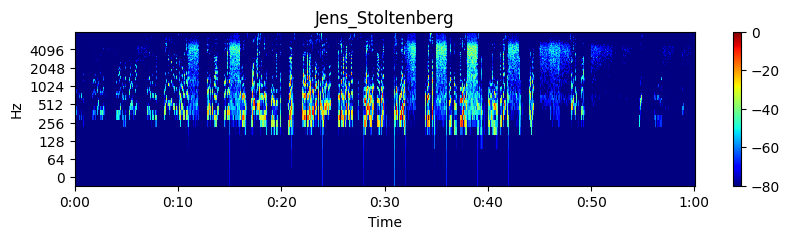


MFCC of Jens_Stoltenberg:


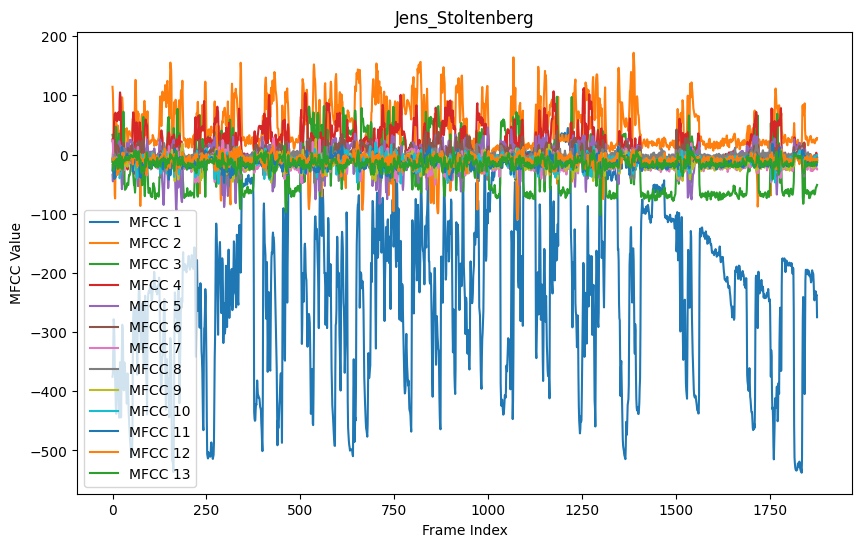

In [ ]:
remove_and_plot("Jens_Stoltenberg")

Waveform of Julia_Gillard (15 seconds):


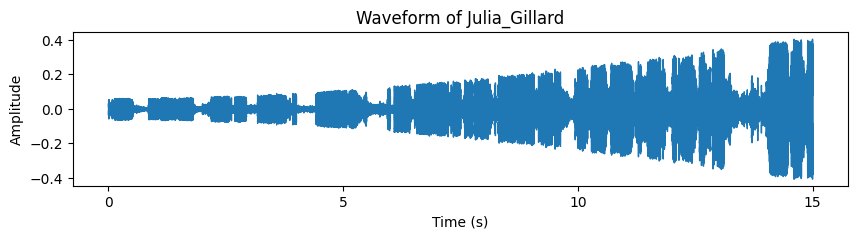


Spectrogram of Julia_Gillard (2 minutes):


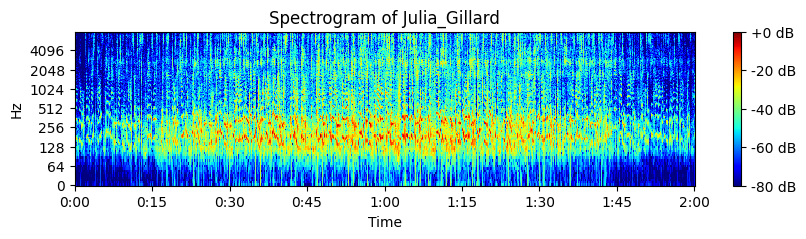


Mel Spectogram of Julia_Gillard:


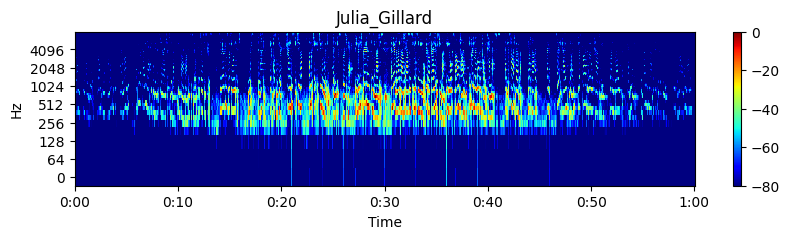


MFCC of Julia_Gillard:


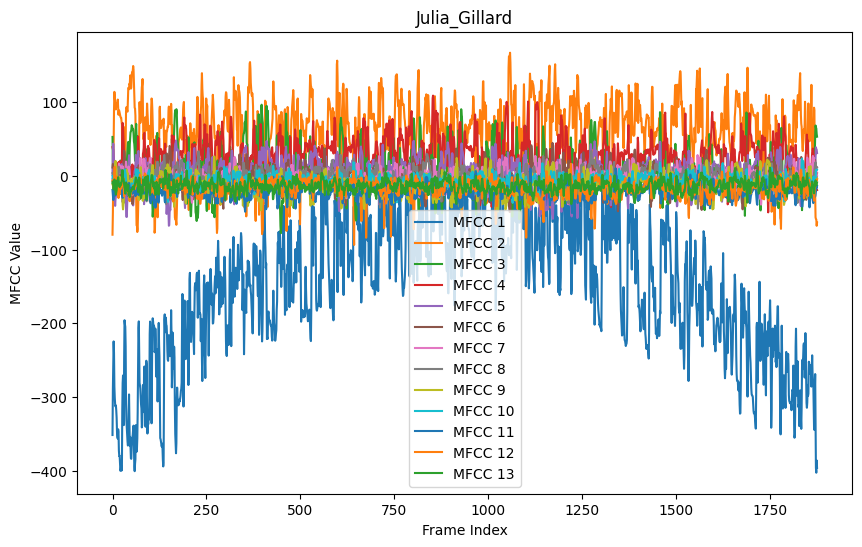

In [ ]:
remove_and_plot("Julia_Gillard")

Waveform of Magaret_Tarcher (15 seconds):


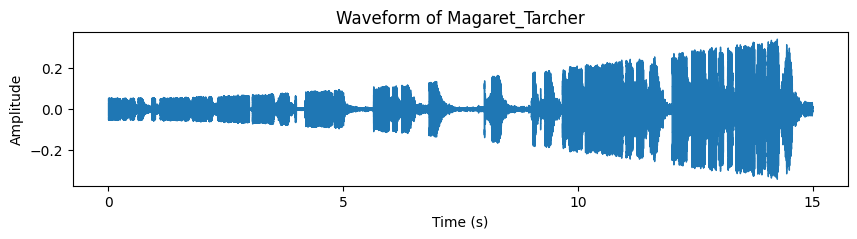


Spectrogram of Magaret_Tarcher (2 minutes):


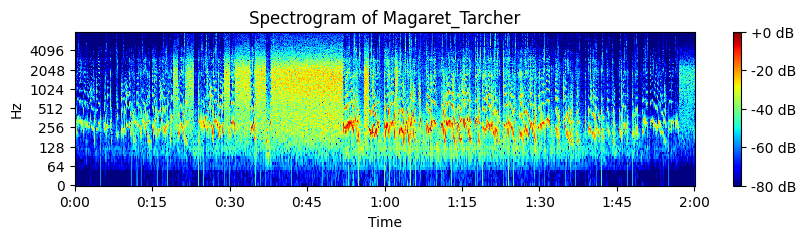


Mel Spectogram of Magaret_Tarcher:


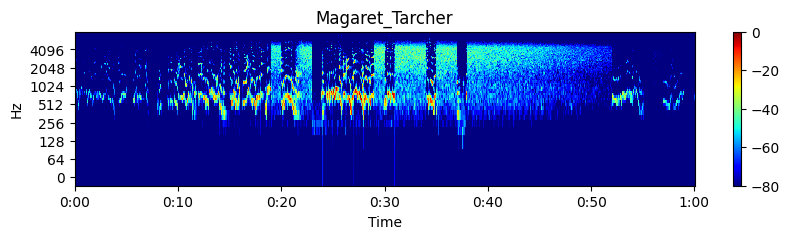


MFCC of Magaret_Tarcher:


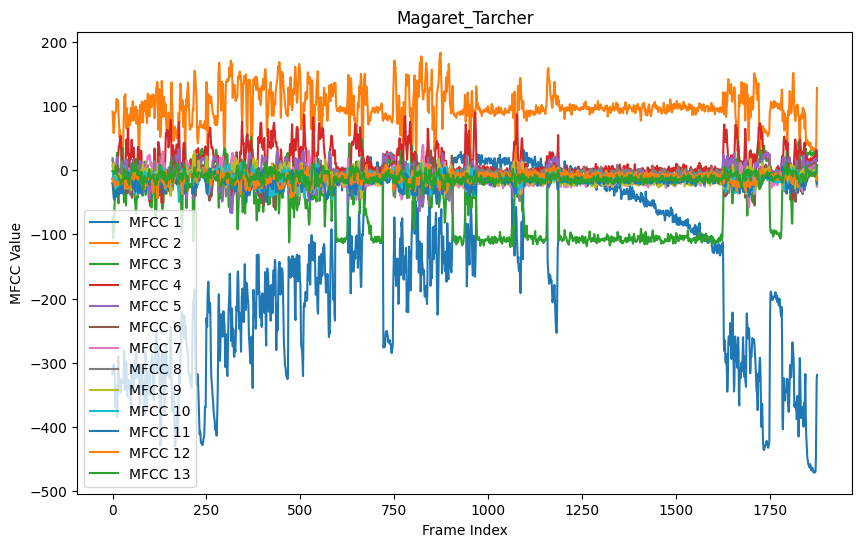

In [ ]:
remove_and_plot("Magaret_Tarcher")

Waveform of Nelson_Mandela (15 seconds):


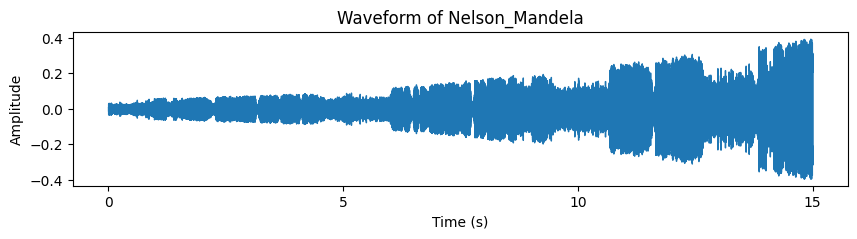


Spectrogram of Nelson_Mandela (2 minutes):


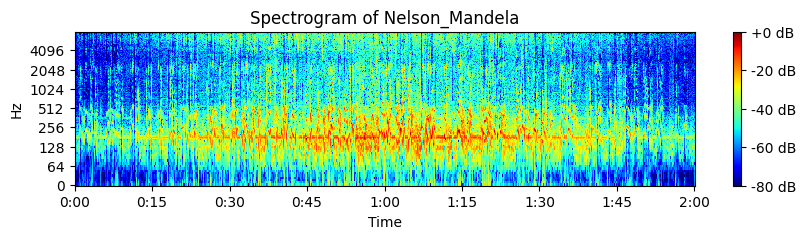


Mel Spectogram of Nelson_Mandela:


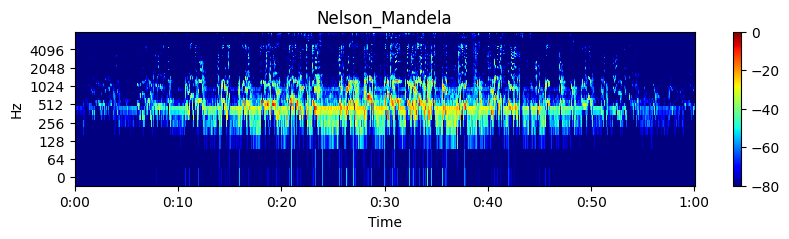


MFCC of Nelson_Mandela:


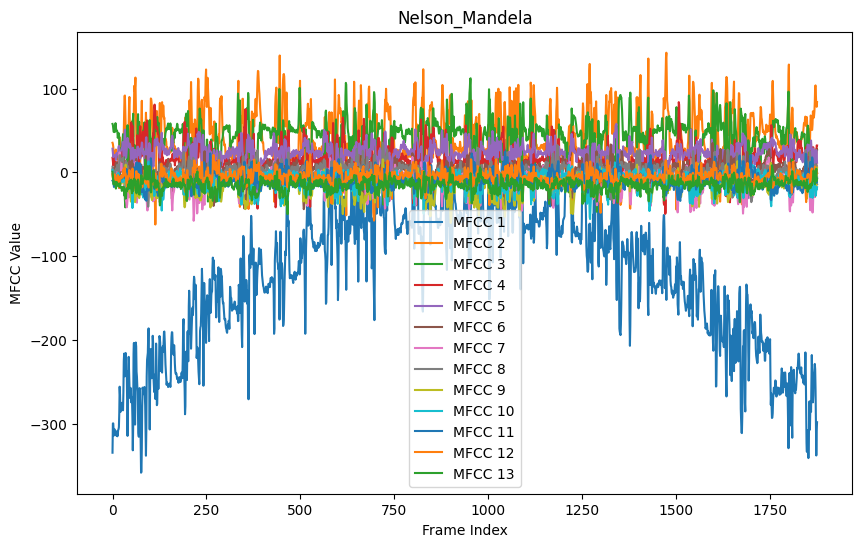

In [ ]:
remove_and_plot("Nelson_Mandela")

## Signal domain transform based on (FFT)

In [ ]:
def get_emphasized_audio(speaker):
    audio_data, sample_rate = get_one_minute_audio(speaker, data_directory)
    clean_audio = remove_noise(audio_data)
    emphasized_audio = pre_emphasis(clean_audio, alpha=0.97)
    return emphasized_audio

In [ ]:
def spectrum_after_fft(speaker):
  fft_result = np.fft.fft(get_emphasized_audio(speaker))
  fft_freq = np.fft.fftfreq(len(fft_result), 1.0 / sample_rate)

  plt.figure(figsize=(10, 4))


  plt.subplot(2, 1, 1)
  plt.title("Audio Waveform")
  plt.plot(np.arange(len(audio_data)) / sample_rate, audio_data)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")


  plt.subplot(2, 1, 2)
  plt.title(f"Spectrum After FFT of {speaker}")
  plt.plot(fft_freq, np.abs(fft_result))
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Magnitude")

  plt.tight_layout()
  plt.show()

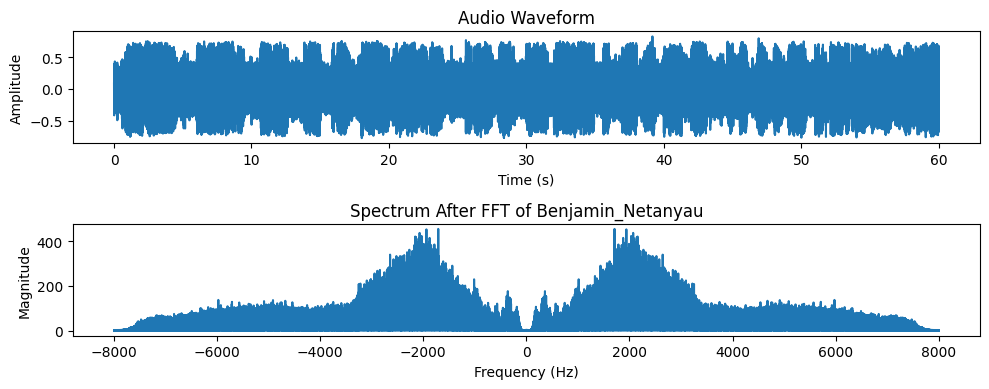

In [ ]:
spectrum_after_fft("Benjamin_Netanyau")

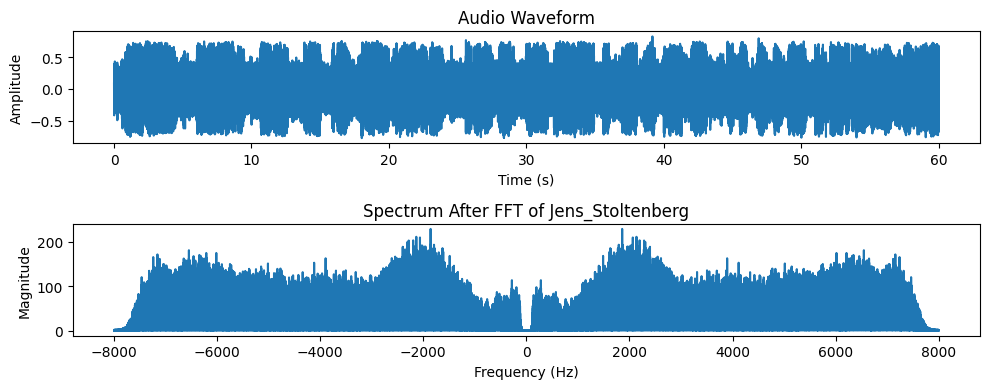

In [ ]:
spectrum_after_fft("Jens_Stoltenberg")

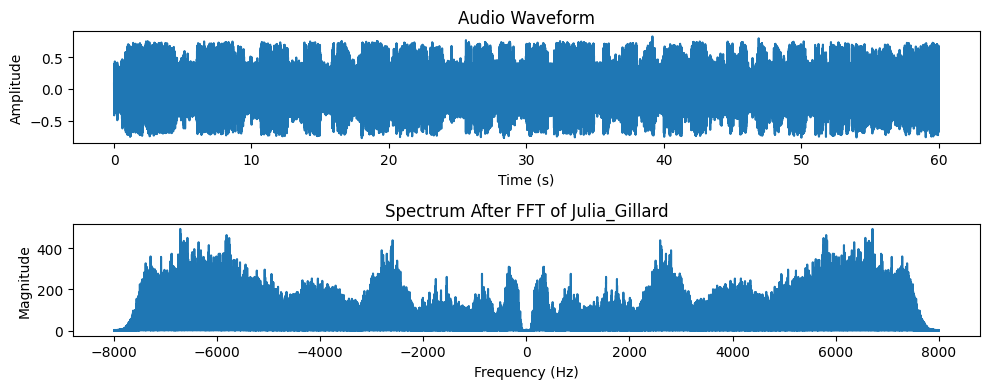

In [ ]:
spectrum_after_fft("Julia_Gillard")

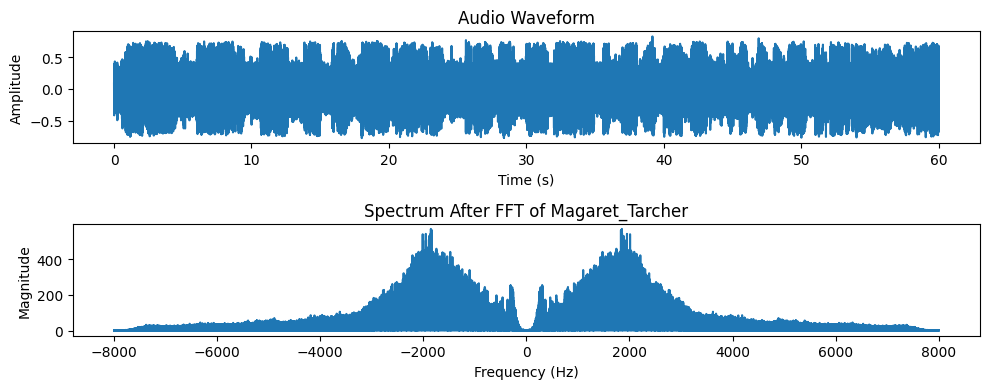

In [ ]:
spectrum_after_fft("Magaret_Tarcher")

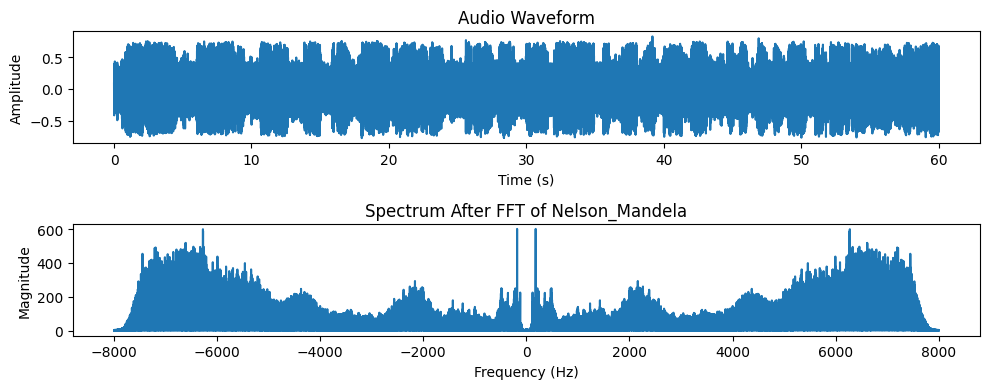

In [ ]:
spectrum_after_fft("Nelson_Mandela")

We can see that  FFT looks different for every speaker. We could model each FFT with a mixture of Gaussian distributions.

# Final Model

### Data Augmentation

In [ ]:
def load_noise_sample(path, target_sr):
    sample, sampling_rate = librosa.load(path, sr=target_sr, mono=True)

    if sampling_rate == target_sr:
        slices = len(sample) // target_sr
        sample = np.split(sample[:slices * target_sr], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None

SAMPLING_RATE = 16000

data_path = "/content/speaker-recognition-dataset/16000_pcm_speeches"
background_noise_path = os.path.join(data_path, '_background_noise_')
other_noise_path = os.path.join(data_path, 'other')

other_noise_files = [os.path.join(other_noise_path, file) for file in os.listdir(other_noise_path)]
background_noise_files = [os.path.join(background_noise_path, file) for file in os.listdir(background_noise_path)]
noise_paths = background_noise_files + other_noise_files

noises = []

for path in noise_paths:
    sample = load_noise_sample(path, target_sr=SAMPLING_RATE)
    if sample:
        noises.extend(sample)

noises = np.vstack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

def add_real_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        rnd_indices = np.random.randint(0, len(noises))
        noise = noises[0]
        prop = np.max(audio) / np.max(noise)
        audio = audio + noise * prop * scale
    return audio

def generate_white_noise(length, amplitude=0.01):
    return amplitude * np.random.randn(length)

def generate_pink_noise(length, amplitude=0.01):
    pink_noise = librosa.effects.preemphasis(np.random.randn(length))
    return amplitude * pink_noise

def adjust_noise_rms(clean_audio, noise_audio, target_snr):
    rms_clean = np.sqrt(np.mean(clean_audio**2))
    rms_noise = np.sqrt(np.mean(noise_audio**2))
    a = (rms_clean / rms_noise) * 10**(-target_snr / 20.0)
    adjusted_noise = noise_audio * a
    mixed_audio = clean_audio + adjusted_noise
    return mixed_audio

6 noise files were split into 354 noise samples where each is 1 sec. long


### Labeling

In [ ]:
data_path = "/content/speaker-recognition-dataset/16000_pcm_speeches"
speakers = ["Benjamin_Netanyau", "Jens_Stoltenberg", "Julia_Gillard", "Magaret_Tarcher", "Nelson_Mandela"]

data = []

for speaker in speakers:
    speaker_path = os.path.join(data_path, speaker)
    for audio_file in os.listdir(speaker_path):
        audio_path = os.path.join(speaker_path, audio_file)
        data.append((audio_path, speaker))

df = pd.DataFrame(data, columns=['Audio_Path', 'Speaker'])
df

Audio_Path            Speaker
0     /content/speaker-recognition-dataset/16000_pcm...  Benjamin_Netanyau
1     /content/speaker-recognition-dataset/16000_pcm...  Benjamin_Netanyau
2     /content/speaker-recognition-dataset/16000_pcm...  Benjamin_Netanyau
3     /content/speaker-recognition-dataset/16000_pcm...  Benjamin_Netanyau
4     /content/speaker-recognition-dataset/16000_pcm...  Benjamin_Netanyau
...                                                 ...                ...
7496  /content/speaker-recognition-dataset/16000_pcm...     Nelson_Mandela
7497  /content/speaker-recognition-dataset/16000_pcm...     Nelson_Mandela
7498  /content/speaker-recognition-dataset/16000_pcm...     Nelson_Mandela
7499  /content/speaker-recognition-dataset/16000_pcm...     Nelson_Mandela
7500  /content/speaker-recognition-dataset/16000_pcm...     Nelson_Mandela

[7501 rows x 2 columns]

### Dataset Splitting

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Speaker'])
train_data, augment_data = train_test_split(train_data, test_size=0.5, random_state=42, stratify=train_data['Speaker'])

### Data Augmentation

In [ ]:
augmented_data = []
clean_data = []

for _, row in augment_data.iterrows():
    audio_path = row['Audio_Path']
    clean_audio, _ = librosa.load(audio_path, sr=16000)
    white_noise = generate_white_noise(len(clean_audio))
    pink_noise = generate_pink_noise(len(clean_audio))
    mixed_audio_white = adjust_noise_rms(clean_audio, white_noise, target_snr=10)
    mixed_audio_pink = adjust_noise_rms(clean_audio, pink_noise, target_snr=10)
    mixed_audio = add_real_noise(clean_audio, noises)
    augmented_data.append((mixed_audio_white, row['Speaker']))
    augmented_data.append((mixed_audio_pink, row['Speaker']))
    augmented_data.append((mixed_audio, row['Speaker']))

for _, row in train_data.iterrows():
    audio_path = row['Audio_Path']
    audio, _ = librosa.load(audio_path, sr=16000)
    clean_data.append((audio, row['Speaker']))

### Feature Extraction

In [ ]:
def extract_mfcc_features(audio):
    mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=13)
    delta_mfccs = librosa.feature.delta(mfccs, order=1)
    features = np.vstack([mfccs, delta_mfccs])
    return features.T

### Training GMM

In [ ]:
speakers_gmm_models = {}

for speaker in speakers:
    clean_speaker_features = [extract_mfcc_features(y[0]) for y in clean_data if y[1] == speaker]
    augmented_speaker_features = [extract_mfcc_features(y[0]) for y in augmented_data if y[1] == speaker]

    speaker_features = clean_speaker_features + augmented_speaker_features
    X_train = np.vstack(speaker_features)

    gmm = GaussianMixture(n_components=30, max_iter=300, reg_covar=0.15)
    gmm.fit(X_train)

    speakers_gmm_models[speaker] = gmm

In [ ]:
all_gmm_models = "speakers_gmm_models.joblib"
# joblib.dump(speakers_gmm_models, all_gmm_models)
speakers_gmm_models = joblib.load(all_gmm_models)
print(f'speakers_gmm_models has {len(speakers_gmm_models)} GMM models')

speakers_gmm_models has 5 GMM models


### Predicting on Testing Data

In [ ]:
def predict_speaker(features):
    max_likelihood = float('-inf')
    predicted_class = None
    for class_label, gmm_model in speakers_gmm_models.items():
        likelihood = gmm_model.score(features)
        if likelihood > max_likelihood:
            max_likelihood = likelihood
            predicted_class = class_label
    return predicted_class

predicted_labels = []

for _, row in test_data.iterrows():
    audio_path = row['Audio_Path']
    audio, _ = librosa.load(audio_path, sr=16000)
    features = extract_mfcc_features(audio)
    speaker = predict_speaker(features)
    predicted_labels.append(speaker)

accuracy = accuracy_score(test_data['Speaker'], predicted_labels)
print(f"Accuracy: {accuracy * 100:.7f}%")

Accuracy: 99.8667259%


### Testing Script

In [ ]:
df = pd.read_csv('')

def split_audio(audio, sample_rate, duration=1):
    segment_length = int(sample_rate * duration)
    num_segments = len(audio) // segment_length
    segments = [audio[i * segment_length: (i + 1) * segment_length] for i in range(num_segments)]
    return segments

predicted_labels_all_files = []

for index, row in df.iterrows():
    wav_file_path = row['audio_file_path']
    audio, sample_rate = librosa.load(wav_file_path, sr=16000)
    audio_segments = split_audio(audio, sample_rate, duration=1)

    predicted_labels = []

    for segment in audio_segments:
        segment_features = extract_mfcc_features(segment)
        predicted_speaker = predict_speaker(segment_features)
        predicted_labels.append(predicted_speaker)

    speaker_counts = {speaker: predicted_labels.count(speaker) for speaker in set(predicted_labels)}

    max_speaker = max(speaker_counts, key=speaker_counts.get)
    predicted_labels_all_files.append(max_speaker)
    print(f"The predicted speaker is: {max_speaker} (Count: {speaker_counts[max_speaker]})")